In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 18/Nov/2020 12:12

In [2]:
%%capture
# %matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np


# Experiments
import run
from uniswap.model.sys_params import sys_params

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (147437, 6, 8, 5)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 406.91s
Execution in 417.4s


In [4]:
fees = [(1-(param/1000))*100 for param in sys_params['fee_numerator']]
conv_tols = [param*100 for param in sys_params['conv_tolerance']]
c_rules = [param for param in sys_params['c_rule']]

In [5]:
experiments

,DAI_balance,ETH_balance,UNI_supply,fee,conv_tol,simulation,subset,run,substep,timestep
0,5900000000000000000000,30000000000000000000,30000000000000000000,0,0.000,0,0,1,0,0
1,5905000000000000000000,29974851607549598219,30000000000000000000,990,0.025,0,0,1,1,1
2,5907000000000000000000,29964804137237704798,30000000000000000000,990,0.025,0,0,1,1,2
3,5905049044963638159408,29974804137237704798,30000000000000000000,990,0.025,0,0,1,1,3
4,5903099384720949983433,29984804137237704798,30000000000000000000,990,0.025,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...
1179499,743946286628305068710709,5636150385127256476394,2451849004991970128609,970,0.005,0,7,7,1,147433
1179500,743875091644524853121178,5636706494502711410282,2451849004991970128609,970,0.005,0,7,7,1,147434
1179501,744236182142741154615450,5634053668549893441728,2451849004991970128609,970,0.005,0,7,7,1,147435
1179502,744236182142741154615450,5634053668549893441728,2451849004991970128609,970,0.005,0,7,7,1,147436


## ANALYSIS

In [6]:
models = list()
for i in experiments['subset'].unique():
    models.append(experiments.loc[experiments['subset']==i,['DAI_balance', 'ETH_balance', 'UNI_supply', 'fee', 'conv_tol']])
    
for df in models:
    df.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply', 'fee', 'conv_tol']
    df.reset_index(inplace=True)

In [17]:
UNI_df = pd.read_pickle('./uniswap_events.pickle')
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

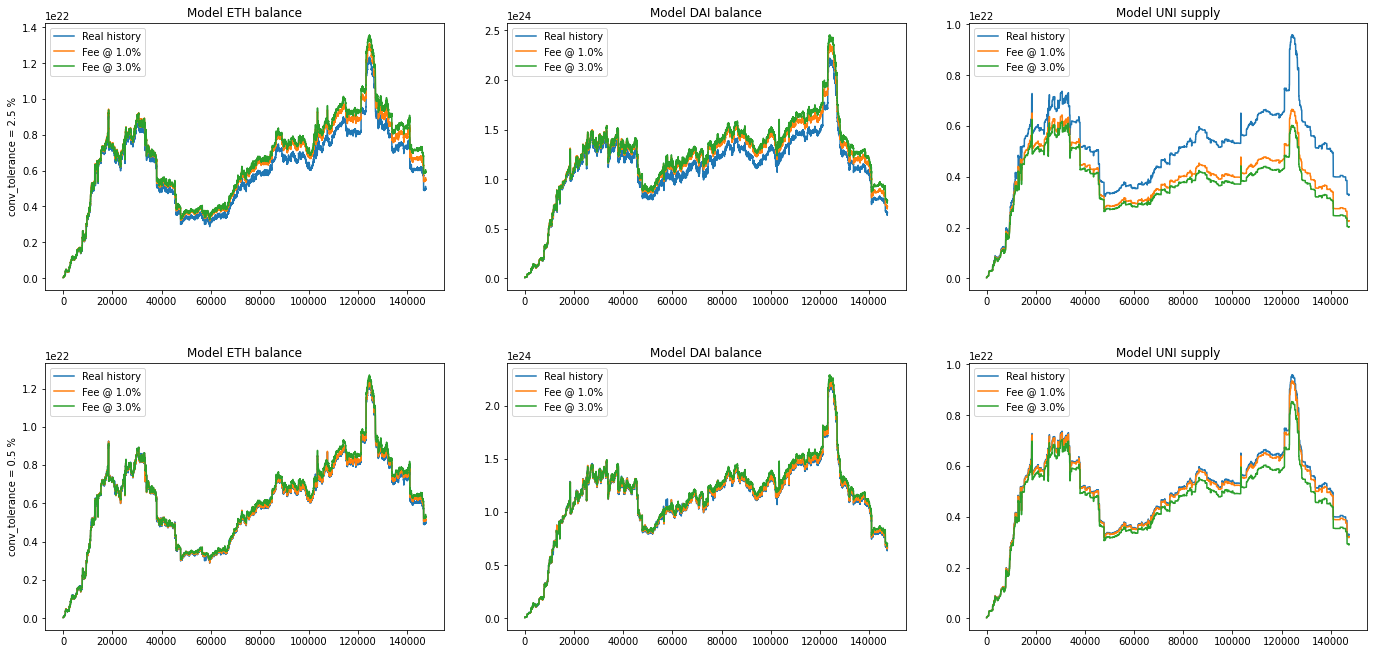

In [10]:
nplots = len(set(fees))
nrows = len(set(conv_tols))
ncols = 3

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(20,10))

plt.close()

for i in range(nrows):
    axs[i][0].plot(real_history['real_ETH_balance'], label='Real history')
    axs[i][1].plot(real_history['real_DAI_balance'], label='Real history')
    axs[i][2].plot(real_history['real_UNI_supply'], label='Real history')
    axs[i][0].set_title('Model ETH balance')
    axs[i][1].set_title('Model DAI balance')
    axs[i][2].set_title('Model UNI supply')
    axs[i][0].set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[i]))
    
    for k in range(nplots):
        axs[i][0].plot(models[nplots*nrows*k + i]['model_ETH_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][1].plot(models[nplots*nrows*k + i]['model_DAI_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][2].plot(models[nplots*nrows*k + i]['model_UNI_supply'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))

    for j in range(ncols):
        axs[i][j].legend(loc='upper left')

fig.tight_layout(pad=4.0)
fig

In [11]:
df = experiments

prev_dai = pd.Series([np.nan]).append(df['DAI_balance'][:-1]).reset_index(drop=True)
prev_eth = pd.Series([np.nan]).append(df['ETH_balance'][:-1]).reset_index(drop=True)
df['delta_dai'] = df['DAI_balance'].diff()
df['delta_eth'] = df['ETH_balance'].diff()
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df['volume'] = df['volume'].fillna(0)
df = df.drop(columns=['delta_dai','delta_eth','istrade'])

In [12]:
def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

In [13]:
plot_data = experiments.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']

a = 0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']
plot_data['50_50_hodler_value'] = a.values

a = plot_data['50_50_hodler_value']/plot_data['50_50_hodler_value'][0] - 1
plot_data['50_50_hodler_return'] = a.values

a = plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1
plot_data['UNI_hodler_return'] = a.values

a = plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1
plot_data['ETH_hodler_return'] = a.values

plots = list()

for i in plot_data['subset'].unique():
    plots.append(plot_data[plot_data['subset'] == i])
for df in plots:
    df.reset_index(inplace=True)

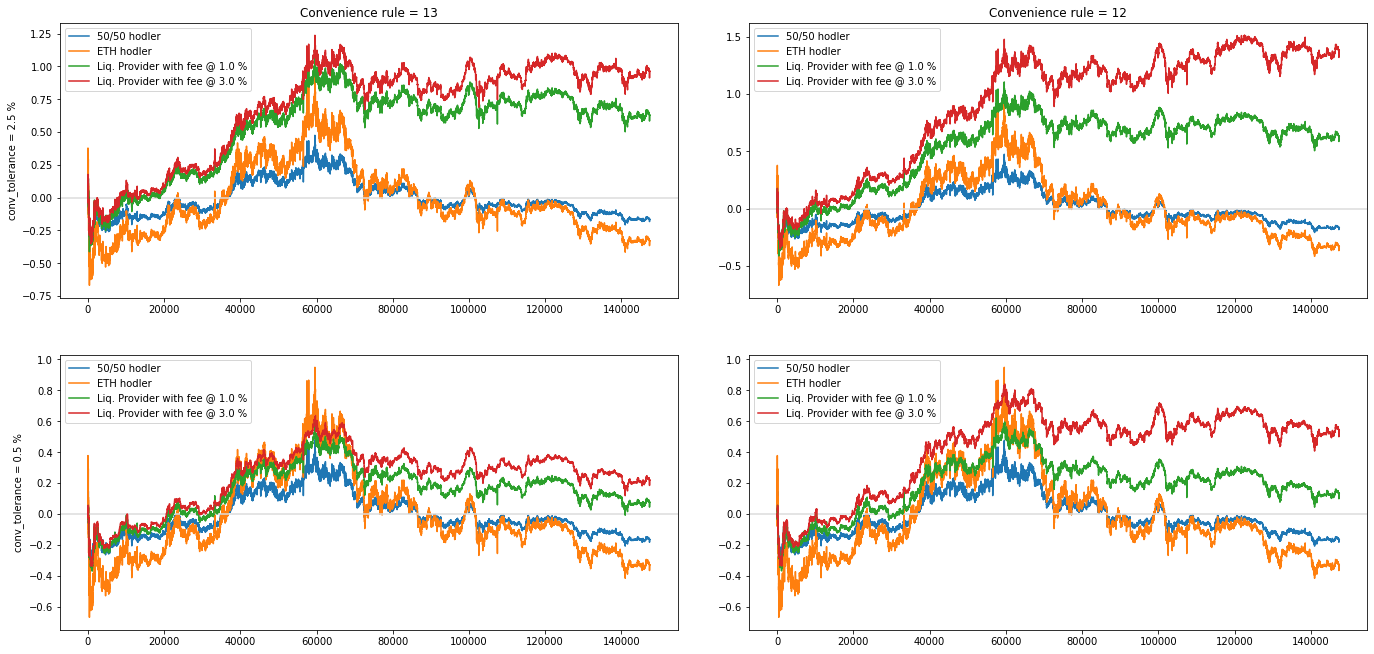

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
from matplotlib import cm
import matplotlib.ticker as ticker

nplots = len(set(fees))
nrows = len(set(conv_tols))
ncols = len(set(c_rules))

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(ncols*10,nrows*5))

plt.close()

if nrows > 1:
    for i in range(nrows):
        if ncols > 1:
            for j in range(ncols):
                axs[i][j].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
                axs[i][j].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
                axs[i][j].axhline(0, color='gainsboro')
                axs[0][j].set_title(f'Convenience rule = {c_rules[ncols*j]}')
                axs[i][0].set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[i]))
                for k in range(nplots):
                    ema = ExpMovingAverage(plots[nplots*nrows*k + ncols*j + i]['UNI_hodler_return'], 1)
                    axs[i][j].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nplots*nrows*k + ncols*j + i]))
            for j in range(ncols):
                axs[i][j].legend(loc='upper left')
        else:
            axs[i].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
            axs[i].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
            axs[i].axhline(0, color='gainsboro')
            axs[0].set_title(f'Convenience rule = {c_rules[0]}')
            axs[i].set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[i])) 
            for k in range(nplots):
                ema = ExpMovingAverage(plots[nrows*k+i]['UNI_hodler_return'], 1)
                axs[i].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nrows*k+i]))
            axs[i].legend(loc='upper left')
            sec_ax = axs[i].twinx()
            sec_ax.set_yscale('log')
else:
    if ncols > 1:
        for i in range(ncols):
            axs[i].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
            axs[i].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
            axs[i].axhline(0, color='gainsboro')
            axs[0].set_title(f'Convenience rule = {c_rules[0]}')
            axs[i].set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[i])) 
            for k in range(nplots):
                ema = ExpMovingAverage(plots[nrows*k+i]['UNI_hodler_return'], 1)
                axs[i].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nrows*k+i]))
            axs[i].legend(loc='upper left')
            sec_ax = axs[i].twinx()
            sec_ax.set_yscale('log')
    else:
        axs.plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
        axs.plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
        axs.axhline(0, color='gainsboro')
        axs.set_title(f'Convenience rule = {c_rules[0]}')
        axs.set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[0])) 
        for j in range(0, nplots):    
            ema = ExpMovingAverage(plots[j]['UNI_hodler_return'], 1)
            axs.plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[j]))
        axs.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
        axs.yaxis.tick_right()
        axs.legend(loc='upper left')
        axs.set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[0]))
        sec_ax = axs.twinx()
        #     sec_ax.plot(plot_data.loc[i]['volume'], label='Volume')
        sec_ax.set_yscale('log')

fig.tight_layout(pad=4.0)
fig